<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Poverty Prediction</h1> 
<h2 style="text-align: center;" markdown="2">A project of the World Bank's Knowledge for Change Program</h2>
<h3 style="text-align: center;" markdown="3">(KCP, Grant TF0A4534)</h3>


> *This notebook is part of a series that has been developed as an empirical comparative assessment of machine learning classification algorithms applied to poverty prediction. The objectives of this project are to explore how well machine learning algorithms perform when given the task to identify the poor in a given population, and to provide a resource of machine learning techniques for researchers, data scientists, and statisticians in developing countries.*

<h1 style="text-align: center;" markdown="3">Algorithm 4 - Bernoulli Naive Bayes Classifier</h1> 
<h2 style="text-align: center;" markdown="3">Part 2: Indonesia Poverty Prediction</h2> 

# Table of Contents
[Introduction](#introduction)  
[Bernoulli Naive Bayes with Simple Features](#simple-feats)  
[Bernoulli Naive Bayes with Full Features](#full-feats)  
&nbsp;&nbsp;&nbsp;[Undersampling](#undersampling)  
&nbsp;&nbsp;&nbsp;[Oversampling](#oversampling)  
&nbsp;&nbsp;&nbsp;[Tune Parameters and Cross-Validate](#tune-cv)  
[Calibration with Platt Scaling](#calibration)  
[Feature Selection](#feature-selection)  
[Summary](#summary)

# Introduction <a class="anchor" id="introduction"></a>

We will now apply the Bernoulli Naive Bayes classifier to the Indonesia dataset and explore how having an unbalanced dataset impacts the classifier performance. 

As always, we start with loading our standard libraries and the Indonesia data

In [1]:
%matplotlib inline

import os
import sys
import json

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from features.process_features import get_vif, standardize
from features.process_features import IDN_BASIC_FEATURES

ALGORITHM_NAME = 'nb'
COUNTRY = 'idn'
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = get_country_filepaths(COUNTRY)

# load text of survey questions for reference
with open(QUESTIONS_PATH, 'r') as fp:
    questions = json.load(fp)

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load training data
X_train, y_train, w_train = split_features_labels_weights(TRAIN_PATH)

# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}' \
        .format(*y_train.poor.value_counts(normalize=True, ascending=True)))

# print first 5 rows of data
X_train.head()

Data has 53,132 rows and 453 columns
Percent poor: 9.0% 	Percent non-poor: 91.0%


,geo_district,geo_subdistrict,geo_village,der_hhsize,hld_nbcell,der_nchild10under,der_nmalesover10,der_nfemalesover10,der_nliterate,der_nemployedpast3mo,...,cons_333__Yes,cons_334__Yes,cons_335__Yes,cons_336__Yes,cons_338__Yes,cons_339__Yes,cons_340__Yes,cons_341__Yes,cons_342__Yes,cons_343__Yes
hid,,,,,,,,,,,,,,,,,,,,,
8271030150650101,8271,30,15,5,1,1,2,2,5,1,...,1,0,0,0,0,0,0,0,0,0
7316020200500509,7316,20,13,5,1,4,0,1,2,0,...,1,0,0,0,0,0,0,0,0,0
5108050200860107,5108,50,4,3,0,0,0,3,0,2,...,0,0,0,0,0,0,0,0,1,0
3301190201430210,3301,190,15,2,1,0,1,1,2,2,...,0,0,0,0,0,0,0,0,0,0
6304140250030508,6304,140,4,6,4,1,3,2,5,3,...,0,0,0,0,0,0,0,0,0,0


# Bernoulli Naive Bayes with simple features <a class="anchor" id="simple-feats"></a>

We'll start with the simple set of features stored in `IDN_BASIC_FEATURES` in the `process_features` module.

In [3]:
# Select the basic features we've used previously
selected_columns = IDN_BASIC_FEATURES
print("X shape with selected columns:", X_train[selected_columns].shape)

X shape with selected columns: (53132, 9)


CPU times: user 23.8 ms, sys: 3.85 ms, total: 27.7 ms
Wall time: 27.6 ms
CPU times: user 19.8 ms, sys: 0 ns, total: 19.8 ms
Wall time: 39.8 ms
In-sample score: 90.54%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


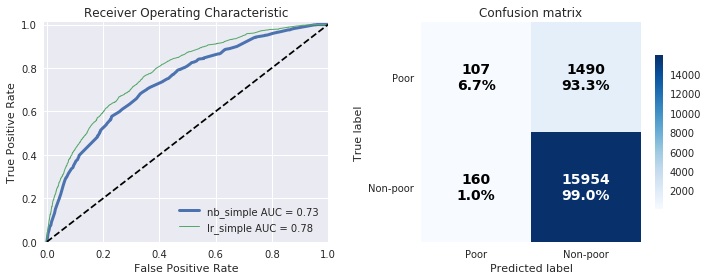

,nb_simple,lr_simple
accuracy,0.906838,0.91158
recall,0.0670006,0.0851597
precision,0.400749,0.564315
f1,0.114807,0.147987
cross_entropy,0.275322,0.256817
roc_auc,0.734987,0.781848
cohen_kappa,0.0913343,0.127352


Actual poverty rate: 11.38% 
Predicted poverty rate: 1.29% 


In [4]:
from sklearn.naive_bayes import BernoulliNB

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, 
                                      selected_columns=selected_columns)

# Fit the model
model = BernoulliNB()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, 
                                   selected_columns=selected_columns)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, 
                                    compare_models=['lr_simple'],
                                    store_model=True,
                                    model_name='simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

As expected, the basic Naive Bayes classifier has a very poor recall rate on the unbalanced dataset, so once again we will need to apply a sampling method to balance the classes.

# Bernoulli Naive Bayes with all features <a class="anchor" id="full-feats"></a>

Now let's apply the Naive Bayes classifier to the dataset with all features. 

CPU times: user 955 ms, sys: 257 ms, total: 1.21 s
Wall time: 1.23 s
CPU times: user 1 s, sys: 241 ms, total: 1.24 s
Wall time: 1.32 s
In-sample score: 81.44%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


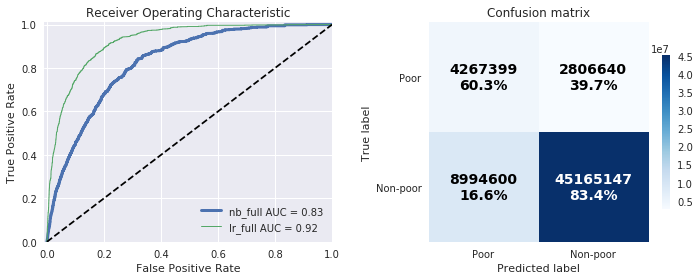

,nb_full,lr_full
accuracy,0.807276,0.910251
recall,0.603248,0.456232
precision,0.321776,0.661838
f1,0.419688,0.540131
cross_entropy,1.89316,0.212947
roc_auc,0.827704,0.923198
cohen_kappa,0.238088,0.483497


Actual poverty rate: 11.38% 
Predicted poverty rate: 21.23% 


In [5]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = BernoulliNB()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models='lr_full',
                                    store_model=True,
                                    model_name='full', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

The overall accuracy of the model has dropped with all features, but we have a much higher recall. However, the precision rate is low, so we are incorrectly classifying a large percentage of non-poor households as poor. 

## Undersampling <a class="anchor" id="undersampling">
Now we'll apply undersampling and see how the performance is affected.

X shape after undersampling:  (9584, 453)
CPU times: user 110 ms, sys: 22.6 ms, total: 133 ms
Wall time: 288 ms
CPU times: user 108 ms, sys: 16.9 ms, total: 125 ms
Wall time: 224 ms
In-sample score: 75.30%
CPU times: user 307 ms, sys: 99.9 ms, total: 407 ms
Wall time: 607 ms
CPU times: user 346 ms, sys: 85.1 ms, total: 431 ms
Wall time: 1.06 s


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


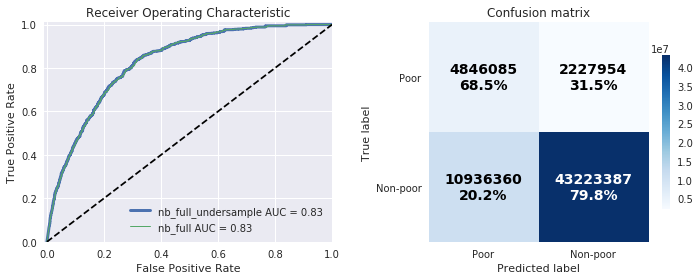

,nb_full_undersample,nb_full
accuracy,0.785016,0.807276
recall,0.685052,0.603248
precision,0.307055,0.321776
f1,0.424045,0.419688
cross_entropy,2.19843,1.89316
roc_auc,0.828384,0.827704
cohen_kappa,0.222983,0.238088


Actual poverty rate: 11.38% 
Predicted poverty rate: 25.17% 


In [6]:
from imblearn.under_sampling import RandomUnderSampler

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply random undersampling
X_train, y_train = RandomUnderSampler().fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after undersampling: ", X_train.shape)

# Fit the model
model = BernoulliNB()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
%time y_pred = model.predict(X_test)
%time y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['nb_full'],
                                    store_model=True,
                                    model_name='full_undersample', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

This actually gives us a very similar performance, but the precision is still very low.

## Oversampling <a class="anchor" id="oversampling">

X shape after oversampling:  (96680, 453)
CPU times: user 919 ms, sys: 425 ms, total: 1.34 s
Wall time: 3.22 s
CPU times: user 940 ms, sys: 374 ms, total: 1.31 s
Wall time: 2.58 s
In-sample score: 76.39%
CPU times: user 390 ms, sys: 77.8 ms, total: 467 ms
Wall time: 681 ms
CPU times: user 340 ms, sys: 92.5 ms, total: 433 ms
Wall time: 543 ms


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


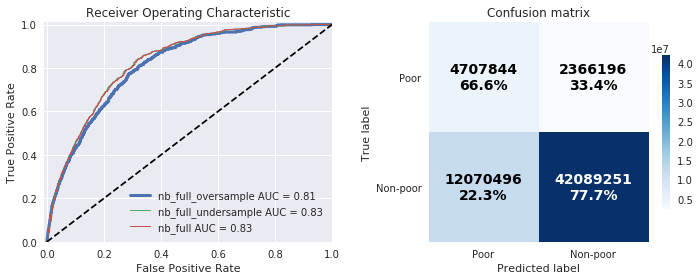

,nb_full_oversample,nb_full_undersample,nb_full
accuracy,0.764236,0.785016,0.807276
recall,0.66551,0.685052,0.603248
precision,0.280591,0.307055,0.321776
f1,0.394748,0.424045,0.419688
cross_entropy,2.05421,2.19843,1.89316
roc_auc,0.81461,0.828384,0.827704
cohen_kappa,0.213252,0.222983,0.238088


Actual poverty rate: 11.38% 
Predicted poverty rate: 26.74% 


In [7]:
from imblearn.over_sampling import SMOTE

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply oversampling with SMOTE
X_train, y_train = SMOTE().fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after oversampling: ", X_train.shape)

# Fit the model
model = BernoulliNB()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
%time y_pred = model.predict(X_test)
%time y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['nb_full_undersample', 
                                                    'nb_full'],
                                    store_model=True,
                                    model_name='full_oversample', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,                                    
                                    features=X_test.columns.values)

Oversampling appears to give us an even lower precision for this classifier

## Tune parameters and cross-validate <a class="anchor" id="tune-cv"></a>

Now we try to find the best value for `alpha` as we did with the Malawi dataset. 

X shape after oversampling:  (96680, 453)
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.1min finished


CPU times: user 1min 14s, sys: 4.2 s, total: 1min 18s
Wall time: 3min 14s
CPU times: user 910 ms, sys: 441 ms, total: 1.35 s
Wall time: 2.45 s
In-sample score: 76.48%
Best model parameters: {'alpha': 1e-10}


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


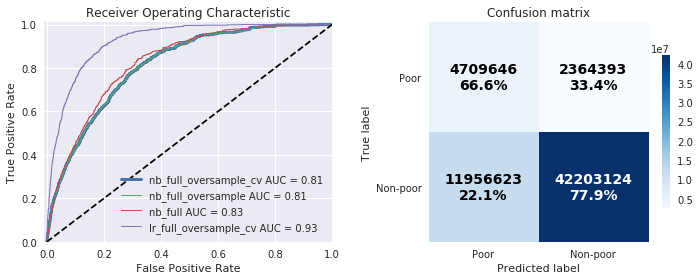

,nb_full_oversample_cv,nb_full_oversample,nb_full,lr_full_oversample_cv
accuracy,0.766126,0.764236,0.807276,0.851611
recall,0.665765,0.66551,0.603248,0.838116
precision,0.282585,0.280591,0.321776,0.427456
f1,0.396764,0.394748,0.419688,0.566159
cross_entropy,2.05139,2.05421,1.89316,0.348544
roc_auc,0.814521,0.81461,0.827704,0.925356
cohen_kappa,0.215532,0.213252,0.238088,0.471316


Actual poverty rate: 11.38% 
Predicted poverty rate: 26.64% 


In [8]:
from sklearn.model_selection import GridSearchCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply oversampling with SMOTE
X_train, y_train = SMOTE().fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after oversampling: ", X_train.shape)

# build the model
estimator = BernoulliNB()
parameters = {'alpha': 10**np.linspace(-10,1,20)}

model = GridSearchCV(estimator, parameters, verbose=1, cv=5, n_jobs=-1)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['nb_full_oversample', 
                                                    'nb_full',
                                                    'lr_full_oversample_cv'],
                                    store_model=True,
                                    model_name='full_oversample_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=X_test.columns.values)

Cross validation for this model has only a minor impact on performance. As with Logistic Regression, we tend to get better recall using undersamping, but better overall performance using oversampling. 

# Classifier Calibration - Platt Scaling <a class="anchor" id="calibration"></a>

X shape after oversampling:  (96680, 453)
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  8.9min finished


CPU times: user 3min 14s, sys: 1min 23s, total: 4min 38s
Wall time: 8min 54s
CPU times: user 928 ms, sys: 375 ms, total: 1.3 s
Wall time: 3.25 s
In-sample score: 76.43%
Best model parameters: {'alpha': 1e-10}
CPU times: user 3.71 s, sys: 1.53 s, total: 5.24 s
Wall time: 10.6 s
CPU times: user 3.03 s, sys: 1.06 s, total: 4.09 s
Wall time: 9.71 s
In-sample score: 76.42%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


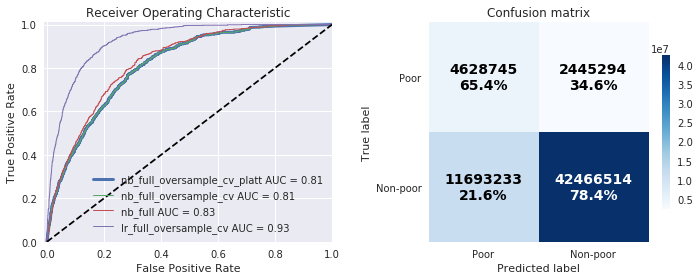

,nb_full_oversample_cv_platt,nb_full_oversample_cv,nb_full,lr_full_oversample_cv
accuracy,0.769106,0.766126,0.807276,0.851611
recall,0.654328,0.665765,0.603248,0.838116
precision,0.28359,0.282585,0.321776,0.427456
f1,0.395687,0.396764,0.419688,0.566159
cross_entropy,0.488522,2.05139,1.89316,0.348544
roc_auc,0.813934,0.814521,0.827704,0.925356
cohen_kappa,0.217217,0.215532,0.238088,0.471316


Actual poverty rate: 11.38% 
Predicted poverty rate: 26.13% 


In [9]:
# platt scaling
from sklearn.calibration import CalibratedClassifierCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply oversampling with SMOTE
X_train, y_train = SMOTE().fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after oversampling: ", X_train.shape)

# build and fit the base model
estimator = BernoulliNB()
parameters = {'alpha': 10**np.linspace(-10,1,20)}
model = GridSearchCV(estimator, parameters, verbose=1, cv=5)
%time model.fit(X_train, y_train)
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)

# Calibrate the model
model = CalibratedClassifierCV(model.best_estimator_, method='sigmoid')
%time model.fit(X_train, y_train)
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['nb_full_oversample_cv', 
                                                    'nb_full',
                                                    'lr_full_oversample_cv'],
                                    store_model=True,
                                    model_name='full_oversample_cv_platt', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,                                    
                                    features=X_test.columns.values)

# Bernoulli Naive Bayes Indonesia Summary <a class="anchor" id="summary"></a>



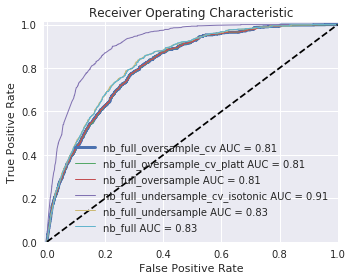

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,pov_rate_error
nb_full_oversample_cv,0.766126,0.665765,0.282585,0.396764,2.05139,0.814521,0.215532,0.152562
nb_full_oversample_cv_platt,0.769106,0.654328,0.28359,0.395687,0.488522,0.813934,0.217217,0.147541
nb_full_oversample,0.764236,0.66551,0.280591,0.394748,2.05421,0.81461,0.213252,0.153641
nb_full_undersample_cv_isotonic,0.788029,0.900186,0.341597,0.495257,0.466896,0.910961,0.358213,0.187183
nb_full_undersample,0.785016,0.685052,0.307055,0.424045,2.19843,0.828384,0.222983,0.137865
nb_full,0.807276,0.603248,0.321776,0.419688,1.89316,0.827704,0.238088,0.0984808


In [10]:
evaluation.compare_algorithm_models(ALGORITHM_NAME, COUNTRY)